# Новый Python интерфейс BigARTM.

## Пример №1

Здесь приводится простой пример использования нового пользовательского интерфейса на Python библиотеки BigARTM. Мы будем обучать тематическую модель маленькой коллекции 'kos'.
Для начала подключим все необходимые модули (убедитесь, что путь к Python API BigARTM находится в вашей переменной PATH):

In [1]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt

import artm

Первым делом создадим тематическую модель. Новый интерфейс позволяет сделать это в одну строчку:

In [2]:
model = artm.ARTM(num_topics=15,
                  num_document_passes=10,
                  scores=[artm.PerplexityScore(name='PerplexityScore')],
                  regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-2.0)])

ARTM — это объект, содержащий в себе всю информацию о текущем состоянии тематической модели. Регуляризаторы и функционалы можно добавлять прямо в конструкторе, что и было сделано.

Создадим объект BatchVectorizer, представляющий собой входные данные библиотеки. При наличии батчей он создаётся на их основе, иначе производится парсинг из файлов 'docword' и 'vocab' в формате UCI:

In [3]:
batch_vectorizer = None
if len(glob.glob('kos' + "/*.batch")) < 1:
    batch_vectorizer = artm.BatchVectorizer(data_path='', data_format='bow_uci', collection_name='kos', target_folder='kos')
else:
    batch_vectorizer = artm.BatchVectorizer(data_path='kos', data_format='batches')

Следующий шаг — инициализация модели. Сделаем это по словарю, что означает, что
- будет создана матрица Фи с именем 'pwt', число строк и столбцов в ней будет взято исходя из числа слов в словаре и заданного в модели числа тем;
- эа матрица будет заполнена случайными значениями из диапазона (0, 1) и нормализована.

Надо отметить, что этот шаг является опциональным, поскольку модель может быть автоматически инициализирована во время вызовов fit_offline() / fit_online().

In [4]:
model.load_dictionary(dictionary_name='dictionary', dictionary_path='kos/dictionary')
model.initialize(dictionary_name='dictionary')

ARTM предоставляет возможность использовать все функционалы качества, имеющиеся в BigARTM. Если функционал подключен к модели, то модель будет сохранять все его значения, полученные на момент каждого обновления матрицы Фи. Функционалы и регуляризаторы можно добавлять отдельно, не только в конструкторе.

Для контроля за качеством получаемой модели введём ещё две метрики:

In [5]:
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))

Также полезно добавить базовые регуляризаторов, повышающих разреженность и различность тем (зададим им стартовые коэффициенты регуляризации, которые можно будет позже изменить)

In [6]:
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=100000.0))

Теперь попробуем обучить модель в оффлайн-режиме (т.е. обновляя Фи раз за проход по коллекции). Инициируем пять проходов:

In [7]:
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)

Проверим результаты первой итерации обучения:

In [8]:
print 'Sparsity Phi:' + str(model.score_tracker['SparsityPhiScore'].last_value)
print 'Sparsity Theta:' + str(model.score_tracker['SparsityThetaScore'].last_value)

Sparsity Phi:0.420696978473
Sparsity Theta:0.703848396501


Видно, что разреженности матриц пока ещё слишком невелики. Попробуем увеличить по модулю значения коэффициентов регуляризации при разреживающих регуляризаторах:

In [9]:
model.regularizers['SparsePhi'].tau = -0.4
model.regularizers['SparseTheta'].tau = -3.0

Также полезно добавить функционал 'TopTokensScore'. Он позволит нам увидеть самые вероятные слова в каждой полученной теме

In [10]:
model.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=5))

Продолжим обучение модели, инициировав 15 проходов по коллекции:

In [11]:
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [12]:
print 'Sparsity Phi:' + str(model.score_tracker['SparsityPhiScore'].last_value)
print 'Sparsity Theta:' + str(model.score_tracker['SparsityThetaScore'].last_value)

Sparsity Phi:0.627425427165
Sparsity Theta:0.797329446064


Разреженность всё ещё неудовлетворительная. Попробуем ещё усилить разреживание и продолжить обучение:

In [13]:
model.regularizers['SparsePhi'].tau = -1.5
model.regularizers['SparseTheta'].tau = -5.0
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

Нарисуем графики перплексии и разреженностей:

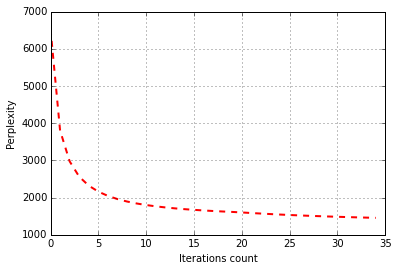

In [14]:
plt.plot(xrange(model.num_phi_updates), model.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Perplexity')
plt.grid(True)
plt.show()

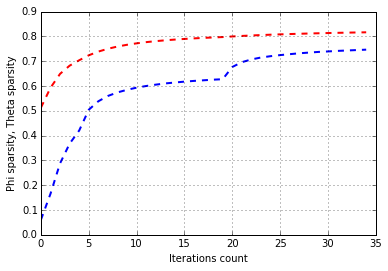

In [15]:
plt.plot(xrange(model.num_phi_updates), model.score_tracker['SparsityPhiScore'].value, 'b--',
         xrange(model.num_phi_updates), model.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Phi sparsity, Theta sparsity')
plt.grid(True)
plt.show()

Для столь маленькой коллекции разреженность достаточная. Напечатаем топовые слова в каждой теме:

In [16]:
for topic_name in model.topic_names:
    print topic_name + ': ',
    print model.score_tracker['TopTokensScore'].last_topic_info[topic_name].tokens

@topic_0:  [u'bush', u'rights', u'law', u'states', u'court']
@topic_1:  [u'iraq', u'iraqi', u'war', u'military', u'troops']
@topic_2:  [u'november', u'poll', u'electoral', u'governor', u'account']
@topic_3:  [u'senate', u'republican', u'carson', u'debate', u'coburn']
@topic_4:  [u'specter', u'toomey', u'hoeffel', u'workers', u'sessions']
@topic_5:  [u'dean', u'edwards', u'kerry', u'clark', u'primary']
@topic_6:  [u'state', u'race', u'senate', u'nader', u'candidate']
@topic_7:  [u'jobs', u'administration', u'years', u'billion', u'bush']
@topic_8:  [u'campaign', u'party', u'dean', u'democratic', u'unions']
@topic_9:  [u'house', u'republican', u'million', u'democrats', u'money']
@topic_10:  [u'november', u'voting', u'vote', u'account', u'electoral']
@topic_11:  [u'bush', u'iraq', u'war', u'administration', u'president']
@topic_12:  [u'bush', u'kerry', u'poll', u'percent', u'voters']
@topic_13:  [u'media', u'time', u'news', u'people', u'house']
@topic_14:  [u'bush', u'kerry', u'guard', u'g

Извлечём матрицу Фи в виде pandas.DataFrame и напечатаем её (в случае необходимости, можно извлекать части матрицы с помощью метода ARTM.get_phi()):

In [17]:
print model.phi_

            @topic_0  @topic_1  @topic_2  @topic_3  @topic_4  @topic_5  \
aarp        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
abandon     0.000493  0.000000  0.000000  0.000153  0.000000  0.000000   
abandoned   0.000000  0.000203  0.000000  0.000000  0.000000  0.000000   
abandoning  0.000024  0.000000  0.000000  0.000000  0.000000  0.000094   
abb         0.000456  0.000000  0.000000  0.000000  0.000000  0.000000   
abc         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
abcs        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
abdullah    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ability     0.000441  0.000000  0.000000  0.000000  0.000000  0.000203   
aboard      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
abortion    0.002729  0.000000  0.000000  0.000251  0.000000  0.000000   
abortions   0.000425  0.000000  0.000000  0.000000  0.000000  0.000000   
abraham     0.000000  0.000000  0.0000

Последний шаг — сохранение модели с возможностью последующей загрузки:

In [18]:
model.save(filename='kos_artm_model')

Дополнительно извлечём Тету:

In [19]:
theta_matrix = model.fit_transform()

ARTM.fit_transform() возвращает Теут как объект pandas.DataFrame. Напечатаем её:

In [20]:
print theta_matrix

           2001      2002  2003      2004      2005  2006      2007  2008  \
@topic_0      0  0.000000     0  0.000000  0.000000     0  0.000000     0   
@topic_1      0  0.000000     0  0.258220  0.000000     0  0.000000     0   
@topic_2      0  0.000000     0  0.000000  0.000000     1  0.000000     0   
@topic_3      0  0.000000     0  0.000000  0.000000     0  0.000000     0   
@topic_4      0  0.000000     0  0.000000  0.000000     0  0.000000     0   
@topic_5      0  0.661333     1  0.093464  0.858208     0  0.000000     1   
@topic_6      0  0.000000     0  0.000000  0.000000     0  0.505188     0   
@topic_7      0  0.000000     0  0.456537  0.000000     0  0.000000     0   
@topic_8      0  0.338667     0  0.000000  0.000000     0  0.313320     0   
@topic_9      1  0.000000     0  0.000000  0.000000     0  0.000000     0   
@topic_10     0  0.000000     0  0.000000  0.000000     0  0.000000     0   
@topic_11     0  0.000000     0  0.191780  0.000000     0  0.000000     0   

## Пример №2

Это вторая часть примера использования нового интерфейса библиотеки. Загрузим обратно модель, сохранённую в прошлой части и применим к ней несколько операций.

В первую очередь создадим новую тематическую модель:

In [21]:
new_model = artm.ARTM(num_topics=1, num_document_passes=1)

Вторым шагом добавим в неё функционалы и регуляризаторы. Ограничимся одной новой метрикой и двумя уже знакомыми регуляризаторами:

In [22]:
new_model.scores.add(artm.TopicKernelScore(name='TopicKernelScore'))
new_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
new_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=100000.0))

Теперь загрузим файл 'kos_artm_model' с моделью обратно в библиотеку

In [23]:
new_model.load('kos_artm_model')

Имейте ввиду, что загружаемая модель перепишет несколько параметров нашего объекта ARTM: число и имена тем, матрицу Фи. Также загрузка сотрёт всю информацию о данных метрик, посчитанных ранее. Тем не менее, сами подключенные метрики и регуляризаторы никуда не денуться. В нашем случае это функционал 'TopicKernelScore' и регуляризаторы 'SparsePhi' и 'DecorrealtorPhi'.

Теперь продолжим обучение модели, но, для примера, рассмотрим онлайновый режим. Это означает, что
- число проходов по каждому документу увеличивается
- матрица Фи может быть обновлена произвольное количество раз за один проход по коллекции (но не чаще, чем раз за обработанный батч)
- нам требуется только оин проход по коллекции (но здесь мы сделаем 5, поскольку коллекция 'kos' довольно маленькая).

In [24]:
new_model.num_document_passes = 20
for i in xrange(5):
    new_model.fit_online(batch_vectorizer=batch_vectorizer, update_every=4)

Параметр 'update_every' говорит модели о том, раз в сколько батчей следует обновлять матрицу Фи.

Выведем средние характеристики ядер тем (чистоту и контрастность):

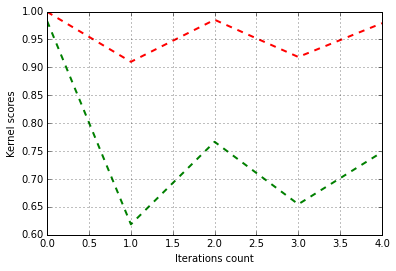

In [25]:
plt.plot(xrange(new_model.num_phi_updates), new_model.score_tracker['TopicKernelScore'].average_contrast, 'g--',
         xrange(new_model.num_phi_updates), new_model.score_tracker['TopicKernelScore'].average_purity, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Kernel scores')
plt.grid(True)
plt.show()

Как мы видим, дальнейшее обучение загруженной модели только ухудшило её качество.

Также можно посмотреть на информацию о ядрах каждой темы. Для примера выведем все ядровые слова первой темы:

In [26]:
print new_model.score_tracker['TopicKernelScore'].last_topic_info[new_model.topic_names[0]].tokens

[u'abandon', u'abb', u'abortion', u'abortions', u'action', u'activist', u'activists', u'acts', u'addition', u'address', u'advocate', u'affairs', u'affect', u'agenda', u'agree', u'agreed', u'allen', u'allowing', u'amendment', u'americas', u'angry', u'antiabortion', u'antigay', u'appeal', u'appealed', u'appealing', u'appeals', u'appears', u'apply', u'appointed', u'areas', u'arent', u'argue', u'argued', u'argument', u'arguments', u'arnold', u'asks', u'assault', u'backed', u'backers', u'ban', u'banning', u'bar', u'base', u'based', u'basic', u'bay', u'believes', u'benefit', u'benefits', u'bishops', u'black', u'blacks', u'blackwell', u'blocked', u'blue', u'body', u'born', u'budgets', u'burden', u'business', u'california', u'calling', u'cap', u'carter', u'catholic', u'catholics', u'ceo', u'checks', u'child', u'children', u'choices', u'christian', u'christians', u'church', u'circuit', u'circumstances', u'citizens', u'civil', u'class', u'clerks', u'closely', u'code', u'colleagues', u'college', 

Если у нас есть батч с документами, который не являлся частью обучающей выборки (или являлся, но мы не сохраняли Тету для экономии памяти), и мы хотим узнать столбцы матрицы Теты для него, то следует использовать метод 'transform()':

In [27]:
test_batch_vectorizer = artm.BatchVectorizer(data_format='batches', data_path='kos_test', batches=['test_docs.batch'])
test_theta_matrix = new_model.transform(batch_vectorizer=test_batch_vectorizer)

ARTM.transform(), как и ARTM.fit_transform(), возвращает Тету в виде объекта pandas.DataFrame. Напечатаем ее:

In [28]:
print test_theta_matrix

                   3001          3002          3003      3004          3005  \
@topic_0   9.710001e-02  2.171972e-02  9.249397e-02  0.136457  7.660367e-02   
@topic_1   7.978157e-02  0.000000e+00  5.726849e-02  0.000000  4.101092e-02   
@topic_2   0.000000e+00  5.166236e-02  0.000000e+00  0.037120  3.127101e-02   
@topic_3   2.007932e-02  1.173555e-02  6.994441e-16  0.052444  6.212139e-02   
@topic_4   0.000000e+00  0.000000e+00  0.000000e+00  0.009470  0.000000e+00   
@topic_5   0.000000e+00  0.000000e+00  1.264643e-02  0.000000  2.155282e-02   
@topic_6   0.000000e+00  3.531644e-16  5.564190e-02  0.013802  0.000000e+00   
@topic_7   7.599327e-07  1.435614e-02  2.989345e-02  0.013328  3.360548e-02   
@topic_8   1.528809e-09  0.000000e+00  1.465404e-14  0.031256  8.907387e-16   
@topic_9   4.936354e-02  4.631601e-01  2.596672e-07  0.117850  1.069807e-01   
@topic_10  2.909726e-09  0.000000e+00  0.000000e+00  0.000000  0.000000e+00   
@topic_11  6.612842e-01  3.461375e-01  5.072100e-01 